# **SMS SPAM DETECTION**

# **INTRODUCTION**

In this project we used text classification to determined whether the messages is spam or not. We used NLP methods to prepare and clean our text data (tokenization, remove stop words, stemming) and different machine learning algorithms to get more accurate predictions. The following classification algorithms have been used: Logistic Regression, Naive Bayes, Support Vector Machine (SVM), Random Forest, Stochastic Gradient Descent and Gradient Boosting.

# **DATASET**
The dataset comes from SMS Spam Collection that can be find at https://www.kaggle.com/uciml/sms-spam-collection-dataset.

This SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It comprises one set of SMS messages in English of 5,574 messages, which is tagged acording being ham (legitimate) or spam.


In [ ]:
import numpy as np
import random
import tensorflow as tf
from sklearn.utils import shuffle

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


# **LOADING LIBRARIES & DATA**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report



**READ CSV FILE INTO DATAFRAME AND DISPLAYS FIRST FIVE ROWS**

In [ ]:
spam = pd.read_csv("/content/Spam_Updates.csv", encoding='latin-1')
spam.head()

,Class,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## **OBSERVATIONS**

**DIMENSIONS OF DATA FRAME**

In [ ]:
spam.shape

(10572, 2)

**SUMMARY OF DATAFRAME**

In [ ]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10572 entries, 0 to 10571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   10572 non-null  object
 1   Text    10572 non-null  object
dtypes: object(2)
memory usage: 165.3+ KB


We have 86 961 words in the data:

**CALCULATE TOTAL NUMBER OF WORDS IN 'TEXT' COLUMN**

In [ ]:
print(spam['Text'].apply(lambda x: len(x.split(' '))).sum())


145805


# **DATA CLEANING**


In [ ]:
spam.head()

,Class,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**RENAME COLUMNS**

In [ ]:
spam.rename(columns={'v1': 'Class', 'v2': 'Text'}, inplace=True)
spam.head()

,Class,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**CHANGE COLUMN CLASS TO 0 & 1**

- spam = 1
- ham = 0

In [ ]:
spam['Class'] = spam['Class'].map({'ham':0, 'spam':1})
spam.head()

,Class,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


**RETRIEVE TEXT FROM SECOND & THIRD ROW**

In [ ]:
spam['Text'][1]

'Ok lar... Joking wif u oni...'

In [ ]:
spam['Text'][2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

# **EDA**

**COUNTING OCCURENCE OF EACH UNIQIE VALUE IN COLUMN ' CLASS '**

In [ ]:
spam['Class'].value_counts()

,count
Class,
1,5747
0,4825


**COUNT OF HAM & SPAM IN COLUMN CLASS**

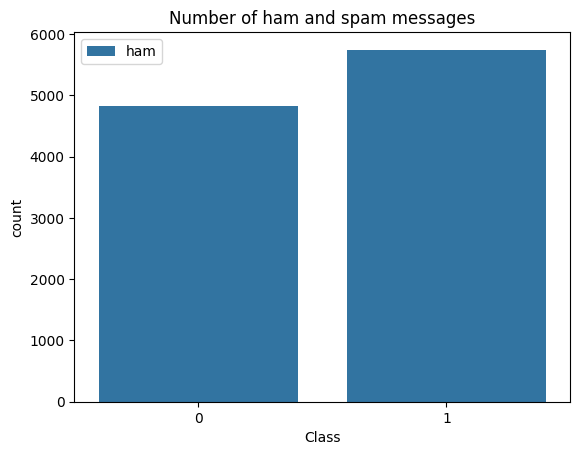

In [ ]:
sns.countplot(x='Class',data=spam)
plt.xlabel('Class')
plt.title('Number of ham and spam messages')
plt.legend(labels=['ham', 'spam']);

The target class variable is imbalanced, where "ham" values are more dominating than "spam".

**STATISTICAL SUMMARY**

In [ ]:
spam.describe()

,Class
count,10572.000000
mean,0.543606
std,0.498118
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


**LENGTH OF TEXT MESSAGE**

In [ ]:
spam['length'] = spam.Text.apply(len)
spam.head()

,Class,Text,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


**MESSAGE LENGTHS FOR HAM & SPAM**

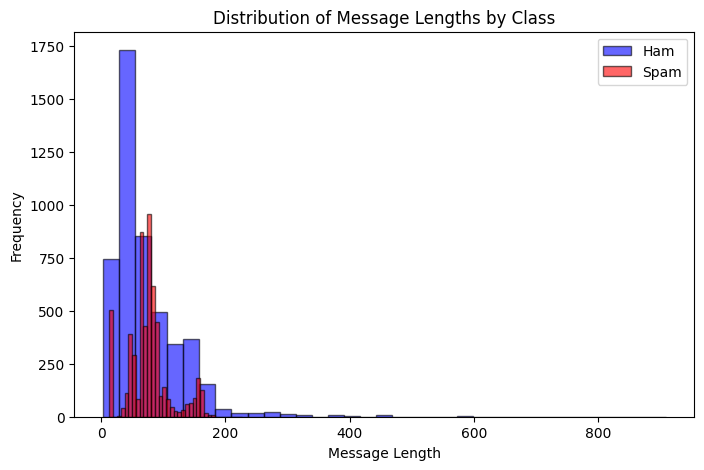

In [ ]:
plt.figure(figsize=(8, 5))

# Plot the histogram for Ham
plt.hist(spam[spam.Class == 0].length, bins=35, color='blue', label='Ham', alpha=0.6, edgecolor='black')

# Plot the histogram for Spam
plt.hist(spam[spam.Class == 1].length, bins=35, color='red', label='Spam', alpha=0.6, edgecolor='black')

# Add labels and legend
plt.legend()
plt.xlabel("Message Length")
plt.ylabel("Frequency")
plt.title("Distribution of Message Lengths by Class")
plt.show()


**IMPORTING NLTK & DOWNLOADING STOP WORDS**

In [ ]:
import nltk

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **TEXT PRE-PROCESSING**

In the next step we clean text, remove stop words and apply stemming operation for each line of text:

In [ ]:
import nltk
stop_words = stopwords.words('english')
print(stop_words[::10])

porter = PorterStemmer()

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [ ]:
def clean_text(words):
    """The function to clean text"""
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()
    return " ".join(text)

def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

def stemmer(stem_text):
    """The function to apply stemming"""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)


In [ ]:
spam['Text'] = spam['Text'].apply(clean_text)
spam.head()

,Class,Text,length
0,0,go until jurong point crazy available only in ...,111
1,0,ok lar joking wif u oni,29
2,1,free entry in a wkly comp to win fa cup final ...,155
3,0,u dun say so early hor u c already then say,49
4,0,nah i don t think he goes to usf he lives arou...,61


**APPLY STOPWORD REMOVAL & STEMMING TO ' TEXT ' COLUMN**

In [ ]:
spam['Text'] = spam['Text'].apply(remove_stopwords)
spam['Text'] = spam['Text'].apply(stemmer)

In [ ]:
spam.head()

,Class,Text,length
0,0,go jurong point crazi avail bugi n great world...,111
1,0,ok lar joke wif u oni,29
2,1,free entri wkli comp win fa cup final tkt st m...,155
3,0,u dun say earli hor u c alreadi say,49
4,0,nah think goe usf live around though,61


**TOTAL NUMBER OF WORDS IN TEXT COLUMN**

In [ ]:
print(spam['Text'].apply(lambda x: len(x.split(' '))).sum())

83602


**SAVE CLEANED DATA**

In [ ]:
spam.to_csv("/content/sample_dataspam_clean.csv")

After text cleaning and removing stop words, we have only 49 940 words.

## **MILESTONE 2**

**VECTORIZATION**

To run machine learning algorithms we need to convert text files into numerical feature vectors.

First we spliting the data into X and y values:

In [ ]:
X = spam['Text']
y = spam['Class']

Now, we create a numerical feature vector for each document:

In [ ]:
vect = TfidfVectorizer(min_df=5, ngram_range=(1,2)).fit(X)
X_tfidf = vect.transform(X)
len(vect.get_feature_names_out())


2459

We spliting the data into train and test sets:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state = 0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8457, 2459)
(2115, 2459)
(8457,)
(2115,)


**SMOTE**

The target class variable is imbalanced, "ham" values are more dominating than "spam".
The simplest way to improve imbalanced dataset is balancing them by oversampling instances of the minority class or undersampling instances of the majority class. We will try to balancing classes by using one of the advanced techniques like the SMOTE method (Synthetic Minority Over-sampling Technique).

SMOTE technique  is one of the most commonly used oversampling methods to solve the imbalance problem. It goal is to balance class distribution by randomly increasing  minority class examples by replicating them.  

We will use imbalanced-learn library to apply SMOTE method:

In [ ]:
smote = SMOTE()
X_train_sm,y_train_sm = smote.fit_resample(X_train,y_train)

In [ ]:
print(X_train_sm.shape)
print(y_train_sm.shape)

(9106, 2459)
(9106,)


## **MILESTONE 3**

### **BUILDING MODELS**

We use the following classification models:

- Logistic Regression,
- Naive Bayes Classifier,
- Random Forest Classifier,
- Gradient Boosting,
- SVM (Support Vector Machine),
- Stochastic Gradient Descent.

To make the vectorizer => transformer => classifier easier to work with, we will use Pipeline class in Scilkit-Learn.




## **LOGISTIC REGRESSION**

In [ ]:
model_lr = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',LogisticRegression()),
                   ])

model_lr.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
pred_y = model_lr.predict(X_test)

In [ ]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.983451536643026
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       921
           1       1.00      0.97      0.99      1194

    accuracy                           0.98      2115
   macro avg       0.98      0.99      0.98      2115
weighted avg       0.98      0.98      0.98      2115



## **NAIVE BAYES**

In [ ]:
model_nb = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',MultinomialNB()),
                   ])

model_nb.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
pred = model_nb.predict(X_test)

In [ ]:
print('accuracy %s' % accuracy_score(pred, y_test))
print(classification_report(ytest, pred))

accuracy 0.9735224586288416
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       921
           1       0.99      0.96      0.98      1194

    accuracy                           0.97      2115
   macro avg       0.97      0.98      0.97      2115
weighted avg       0.97      0.97      0.97      2115



## **RANDOM FOREST CLASSIFIER**

In [ ]:
model_rf = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',RandomForestClassifier(n_estimators=50)),
                   ])

model_rf.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
preds = model_rf.predict(X_test)

In [ ]:
print('accuracy %s' % accuracy_score(preds, y_test))
print(classification_report(ytest, preds))

accuracy 0.9872340425531915
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       921
           1       1.00      0.98      0.99      1194

    accuracy                           0.99      2115
   macro avg       0.99      0.99      0.99      2115
weighted avg       0.99      0.99      0.99      2115



## **GRADIENT BOOSTING**

In [ ]:
model_gb = Pipeline([('tfidf', TfidfTransformer()),
                    ('model', GradientBoostingClassifier(random_state=100, n_estimators=150,min_samples_split=100, max_depth=6)),
                    ])

model_gb.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
y_pred = model_gb.predict(X_test)

In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(ytest, y_pred))

accuracy 0.9820330969267139
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       921
           1       0.99      0.98      0.98      1194

    accuracy                           0.98      2115
   macro avg       0.98      0.98      0.98      2115
weighted avg       0.98      0.98      0.98      2115



## **SUPPORT VECTOR MACHINE**

In [ ]:
model_svc = Pipeline([('tfidf', TfidfTransformer()),
                     ('model',LinearSVC()),
                     ])

model_svc.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
predict = model_svc.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  class LinearSVC(LinearClassifierMixin, SparseCoefMixin, BaseEstimator):


In [ ]:
print('accuracy %s' % accuracy_score(predict, y_test))
print(classification_report(ytest, predict))

accuracy 0.9891252955082742
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       921
           1       1.00      0.98      0.99      1194

    accuracy                           0.99      2115
   macro avg       0.99      0.99      0.99      2115
weighted avg       0.99      0.99      0.99      2115



## **STOCHASTIC GRADIENT DESCENT**

In [ ]:
model_sg = Pipeline([('tfidf', TfidfTransformer()),
                     ('model',SGDClassifier()),
                     ])

model_sg.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
predicted = model_sg.predict(X_test)

In [ ]:
print('accuracy %s' % accuracy_score(predicted, y_test))
print(classification_report(ytest, predicted))

accuracy 0.9886524822695035
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       921
           1       1.00      0.98      0.99      1194

    accuracy                           0.99      2115
   macro avg       0.99      0.99      0.99      2115
weighted avg       0.99      0.99      0.99      2115



# **MILESTONE 4**

## **BEST MODEL**

We tested six different models and now, we check which one is the best:

In [ ]:
log_acc = accuracy_score(pred_y, y_test)
nb_acc = accuracy_score(pred, y_test)
rf_acc = accuracy_score(preds, y_test)
gb_acc = accuracy_score(y_pred, y_test)
svm_acc = accuracy_score(predict, y_test)
sg_acc = accuracy_score(predicted, y_test)

### **CREATE AND SORTS DATAFRAME OF MODEL SCORES**

In [ ]:
models = pd.DataFrame({
                      'Model': ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'Gradient Boosting', 'SVM', 'SGD'],
                      'Score': [log_acc, nb_acc, rf_acc, gb_acc, svm_acc, sg_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
4,SVM,0.989125
5,SGD,0.988652
2,Random Forest,0.987234
0,Logistic Regression,0.983452
3,Gradient Boosting,0.982033
1,Naive Bayes,0.973522


Determines which model has the highest recall by evaluating the models and showing confusion matrices.

Results for Stochastic Gradient Descent:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       921
           1       1.00      0.98      0.99      1194

    accuracy                           0.99      2115
   macro avg       0.99      0.99      0.99      2115
weighted avg       0.99      0.99      0.99      2115

Accuracy: 0.9886524822695035
Precision: 0.9877209281247168
Recall: 0.9893291102635873
Results for Random Forest:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       921
           1       1.00      0.98      0.99      1194

    accuracy                           0.99      2115
   macro avg       0.99      0.99      0.99      2115
weighted avg       0.99      0.99      0.99      2115

Accuracy: 0.9872340425531915
Precision: 0.9860638297872341
Recall: 0.9881969565525783
Results for Naive Bayes:

              precision    recall  f1-score   support

           0       0.95

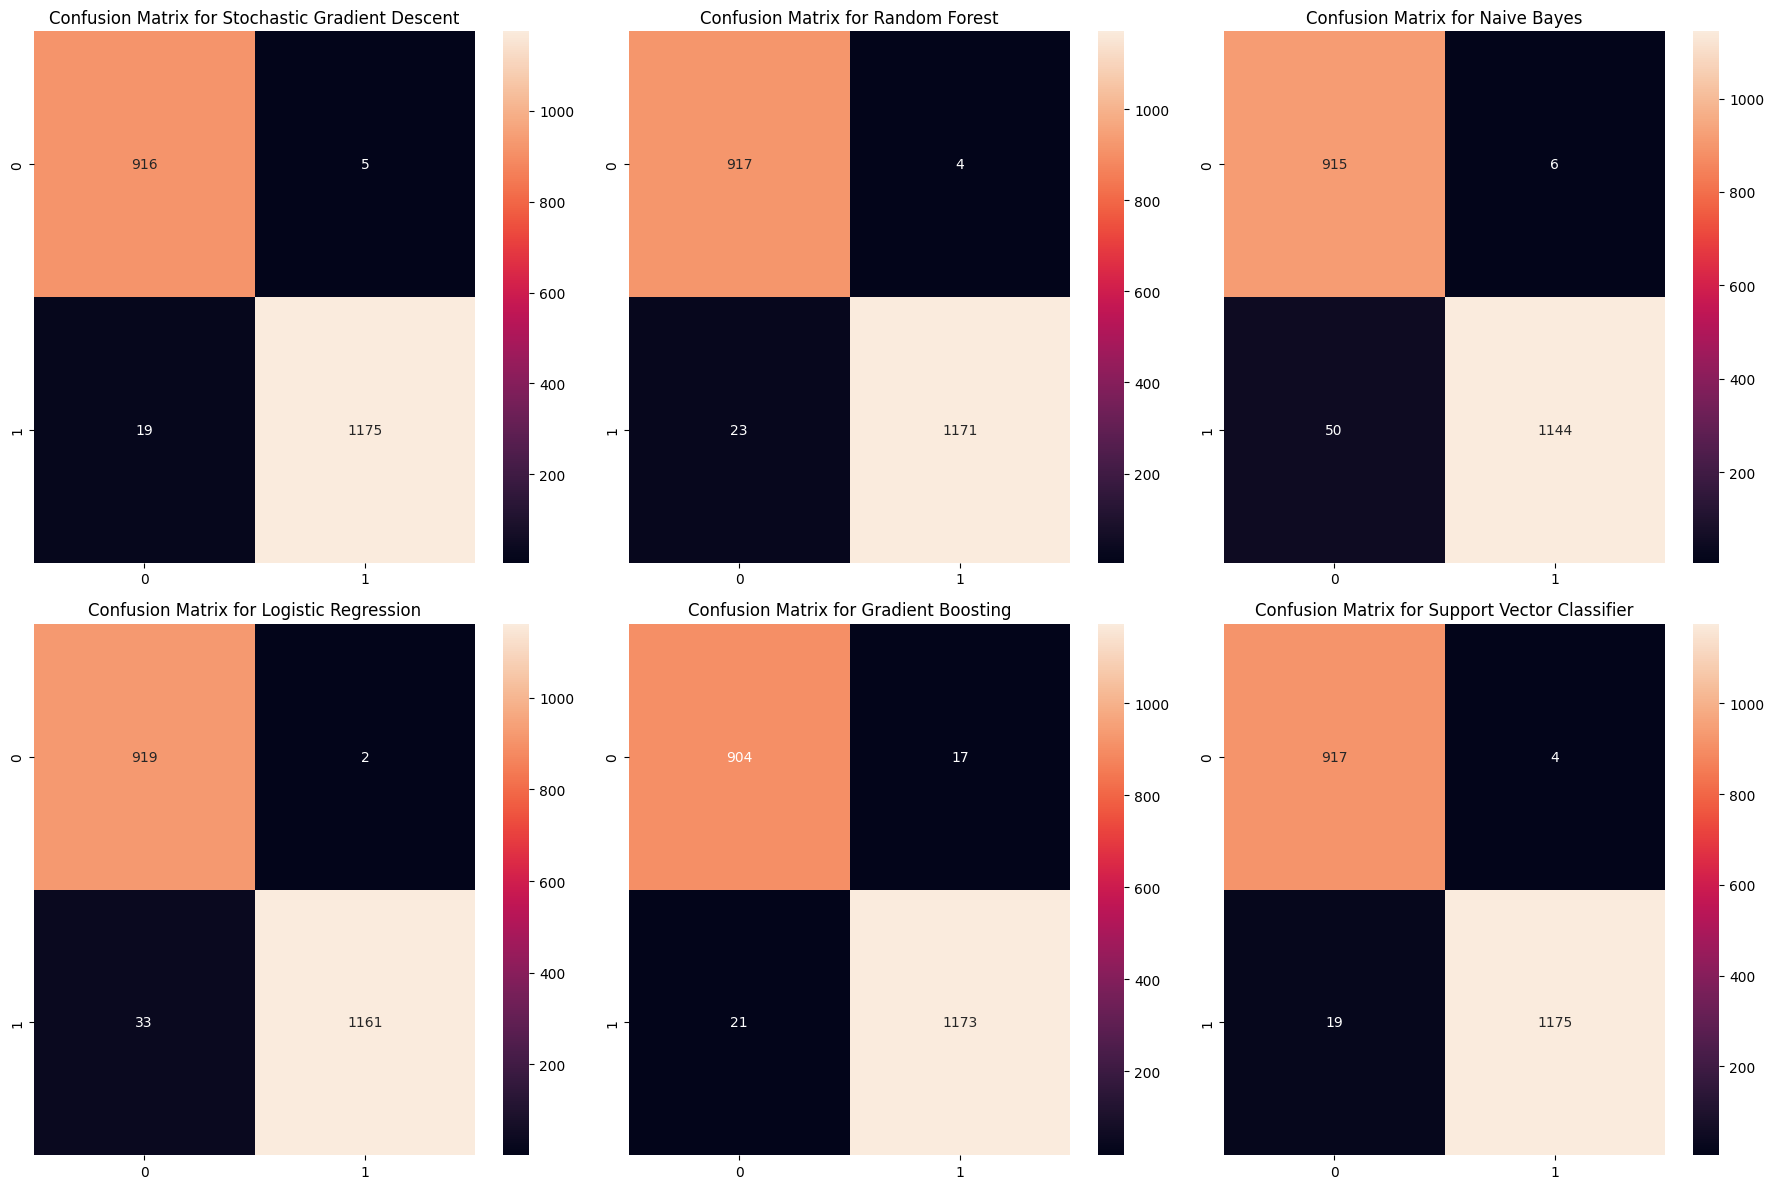

Summary of Model Metrics:

                                    Confusion Matrix  Accuracy  Precision  \
Stochastic Gradient Descent   [[916, 5], [19, 1175]]  0.988652   0.987721   
Random Forest                 [[917, 4], [23, 1171]]  0.987234   0.986064   
Naive Bayes                   [[915, 6], [50, 1144]]  0.973522   0.971485   
Logistic Regression           [[919, 2], [33, 1161]]  0.983452   0.981808   
Gradient Boosting            [[904, 17], [21, 1173]]  0.982033   0.981506   
Support Vector Classifier     [[917, 4], [19, 1175]]  0.989125   0.988154   

                               Recall  
Stochastic Gradient Descent  0.989329  
Random Forest                0.988197  
Naive Bayes                  0.975805  
Logistic Regression          0.985095  
Gradient Boosting            0.981977  
Support Vector Classifier    0.989872  

The best model with the highest recall is Support Vector Classifier with a recall of 0.9898719984286253.


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model(model, X_test, y_test, model_name, ax):
    y_pred = model.predict(X_test)

    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')

    # Store metrics in a dictionary
    metrics[model_name] = {
        'Confusion Matrix': cm,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    }

    # Print metrics
    print(f"Results for {model_name}:\n")
    print(classification_report(y_test, y_pred))
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)
    ax.set_title(f"Confusion Matrix for {model_name}")

# Assuming you have already defined your models
models = [
    ('Stochastic Gradient Descent', model_sg),
    ('Random Forest', model_rf),
    ('Naive Bayes', model_nb),
    ('Logistic Regression', model_lr),
    ('Gradient Boosting', model_gb),
    ('Support Vector Classifier', model_svc)
]

# Initialize dictionary to store metrics
metrics = {}

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()

# Evaluate each model
for idx, (model_name, model) in enumerate(models):
    evaluate_model(model, X_test, y_test, model_name, axs[idx])

# Adjust layout
plt.tight_layout()
plt.show()

# Create a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame.from_dict(metrics, orient='index')

# Print the summary table
print("Summary of Model Metrics:\n")
print(metrics_df)

# Identify the model with the highest recall
best_model_name = metrics_df['Recall'].idxmax()
best_model_recall = metrics_df['Recall'].max()

print(f"\nThe best model with the highest recall is {best_model_name} with a recall of {best_model_recall}.")


## **EXPORTING MODEL & DEPLOYING**

In [ ]:
import pickle
with open('support_vector _classifier.pkl', 'wb') as model_file:
    pickle.dump(model_svc, model_file)

## **CONCLUSION**

This project was aimed to text classification to determined whether the messages is spam or not. We started with the dcleaning and text mining, which cover change text into tokens, remove punctuation, stop words and normalization them by stemming. Following we used bag of words model to convert the text into numerical feature vectors. Finally we started training six different classification models and we got the best accuracy of 0.98 and best recall of 0.98 for Support Vector Classifier method.
